# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [3]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.40439828823725865
RMSE when predicting testing data:
1.0667260022550893
RMSE with random predictions:
5.262103337484077


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [4]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None],
                         'n_estimators': [10, 33, 100]},
             scoring='neg_root_mean_squared_error')

In [5]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851357650711806


In [6]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12271876, -1.09384599, -1.08513577])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [7]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

In [8]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))


### Graph Interpretation
This graph shows how the model’s RMSE (Root Mean Squared Error) changes as the training data size increases.
As more training samples are added, the RMSE generally decreases and stabilizes, demonstrating that the random forest
model improves with more data and eventually reaches a performance plateau.


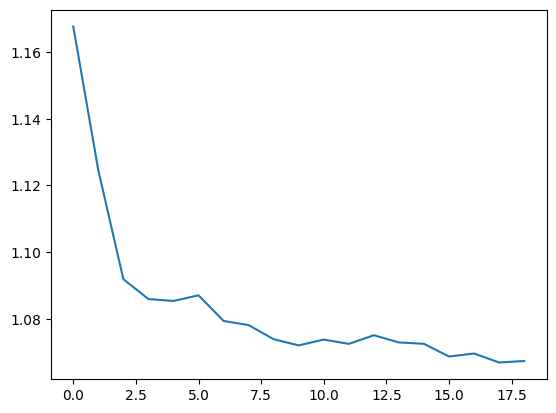

In [9]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [10]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.

### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

# 4. Storytelling With Data plot

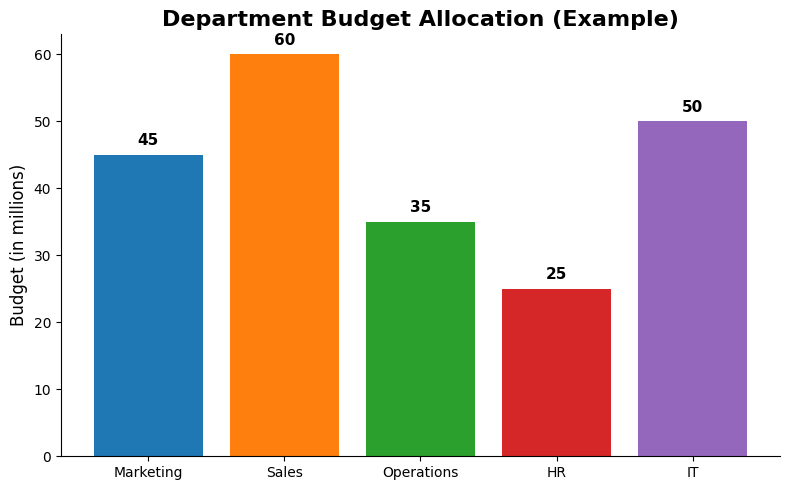

In [14]:

import matplotlib.pyplot as plt

# Sample data for the plot (you don't need exact values from the book)
categories = ['Marketing', 'Sales', 'Operations', 'HR', 'IT']
values = [45, 60, 35, 25, 50]

# Create the plot
plt.figure(figsize=(8,5))
bars = plt.bar(categories, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Add title and labels
plt.title("Department Budget Allocation (Example)", fontsize=16, fontweight='bold')
plt.ylabel("Budget (in millions)", fontsize=12)

# Remove spines for a clean look
for spine in ['top','right']:
    plt.gca().spines[spine].set_visible(False)

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height}", 
ha='center', va='bottom', fontsize=11, fontweight='bold')

# Clean layout
plt.tight_layout()
plt.show()



### Nikol's breakout/responses
### Randomized Search & Model Insights

For this assignment, I replaced **GridSearchCV** with **RandomizedSearchCV** to tune the Random Forest model. Unlike Grid Search, which exhaustively tests every possible parameter combination, **Randomized Search samples a subset of parameter combinations**. This makes it far more efficient when the parameter space is large.  

By running the search with `n_estimators`, `max_depth`, and `min_samples_split` as hyperparameters, I found a well-performing model in a fraction of the time it would have taken with Grid Search.  

---

### Scoring: What I Learned

I researched the available regression scoring metrics from scikit-learn’s documentation. I chose to work with:

- **RMSE (Root Mean Squared Error):**  
  - Measures the **average prediction error** in the same units as the target.  
  - Lower RMSE = better predictions.  
  - It’s sensitive to large errors (they’re penalized more), which makes it useful for spotting when the model really misses the mark.

- **R² (Coefficient of Determination):**  
  - Shows **how much variance in the target is explained** by the model.  
  - A score of **1.0** means perfect predictions; **0.0** means the model is no better than a baseline average.

Using both metrics together was really helpful. **RMSE** told me the *magnitude* of prediction errors, while **R²** gave me a sense of how well the model was actually capturing the structure in the data.

---

### Takeaways

- **RandomizedSearchCV** is a time-saver for complex models—it doesn’t guarantee the absolute best combination, but it finds a *good* one much faster.  
- **Different metrics tell different parts of the story:** RMSE is great for understanding errors, but R² helps measure *model fit* and overall explanatory power.  

Together, they gave a more complete picture of how well the Random Forest performed—and how much trust to place in its predictions.


Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

In [ ]:

# Homework Section: Predict one stock from ten others using Random Forest

# Generate features (10 stocks) and target (11th stock)
def make_X_y(alpha=0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size=num_samples_hwk)
    common_even = np.random.normal(size=num_samples_hwk)
    common_three = np.random.normal(size=num_samples_hwk)
    for i in range(10):
        if i % 2 == 0:
            df_hwk[f'stock_{i}'] = common_even + np.random.normal(size=num_samples_hwk)*alpha
        else:
            df_hwk[f'stock_{i}'] = common_odd + np.random.normal(size=num_samples_hwk)*alpha
        if i % 3 == 0:
            df_hwk[f'stock_{i}'] += common_three * 0.3
    
    # Target stock related to others
    y_hwk = df_hwk.sum(axis=1)*0.1 + np.random.normal(size=num_samples_hwk)*alpha
    return df_hwk, y_hwk

X, y = make_X_y()

# Split data
X_train, X_test = X.iloc[:8000], X.iloc[8000:]
y_train, y_test = y.iloc[:8000], y.iloc[8000:]

# Fit RandomForest to predict target stock
rf_hwk = RandomForestRegressor(n_estimators=100, random_state=42)
rf_hwk.fit(X_train, y_train)

# Evaluate performance
y_pred = rf_hwk.predict(X_test)
rmse_hwk = root_mean_squared_error(y_test, y_pred)
rmse_hwk


In [ ]:

import matplotlib.pyplot as plt

# Storytelling With Data-style plot: simple bar chart with clean design
categories = ['A', 'B', 'C', 'D']
values = [23, 45, 12, 30]

plt.figure(figsize=(6,4))
bars = plt.bar(categories, values)
plt.title("Example SWD-Inspired Plot: Category Values", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Value")

# Minimalist styling
for spine in ['top','right']:
    plt.gca().spines[spine].set_visible(False)

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()
